In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,random_split

from torchsummary import summary

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import time

#### 使用GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### MNIST 数据集

In [4]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root= './data', train = True, download =True, transform = transform)

# 划分训练集、验证集和测试集
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000])
test_dataset = datasets.MNIST(root= './data', train = False, download =True, transform = transform)

In [5]:
# 加载训练集、验证集和测试集
train_mnist = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_mnist = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_mnist = DataLoader(test_dataset, batch_size=64, shuffle=False)

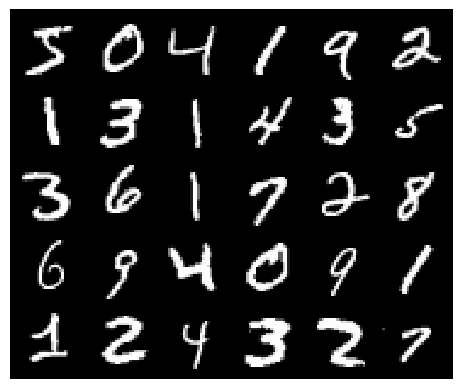

In [6]:
x_train, y_train = dataset.data, dataset.targets

if len(x_train.shape) == 3:
      x_train = x_train.unsqueeze(1)

x_grid = torchvision.utils.make_grid(x_train[:30], nrow=6, padding=2)

npimg = x_grid.numpy()
npimg_tr = np.transpose(npimg, (1, 2, 0))
plt.axis('off')
plt.imshow(npimg_tr, interpolation='nearest')

## VGG-16 预处理模型

In [10]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1}

        noop = lambda x : x
        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x
    

class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256,512, batch_norm=batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(2048, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, num_classes) 
            )

    @property
    def input_size(self):
          return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [11]:
model_mnist = VGG16((1,32,32), batch_norm=True)
model_mnist.to(device) 
model_mnist.load_state_dict(torch.load('./vgg16_mnist_model.pth'))

<All keys matched successfully>

## FGSM 攻击

In [12]:
def perturb(imgs, eps, data_grads):
    sign_data_grads = data_grads.sign()
    adv_imgs = imgs + eps * sign_data_grads
    adv_imgs = torch.clamp(adv_imgs, 0, 1)
    return adv_imgs

def fgsm_attack(model, imgs, labels, eps):
    imgs.required_grad = True
    
    outputs = model(imgs)
    loss = F.nll_loss(outputs, labels)
    
    model.zero_grad()
    loss.backward()
    data_grads = imgs.grad.data
    
    adv_imgs = perturb(imgs, eps, data_grads)
    outputs = model(adv_imgs)
    new_preds = outputs.argmax(axis=1)
    
    return adv_imgs, new_preds

## PGD 攻击

In [13]:
def pgd_linf(model, imgs, labels, epsilon, alpha, num_iter, flag=0):
    delta = torch.zeros_like(imgs, requires_grad=True)
    if flag == 1:
        num_iter = 1
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(imgs + delta), labels)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
        new_preds = model(imgs + delta).argmax(axis=1)
    return (imgs + delta).detach(), new_preds

## 卷积自编码器
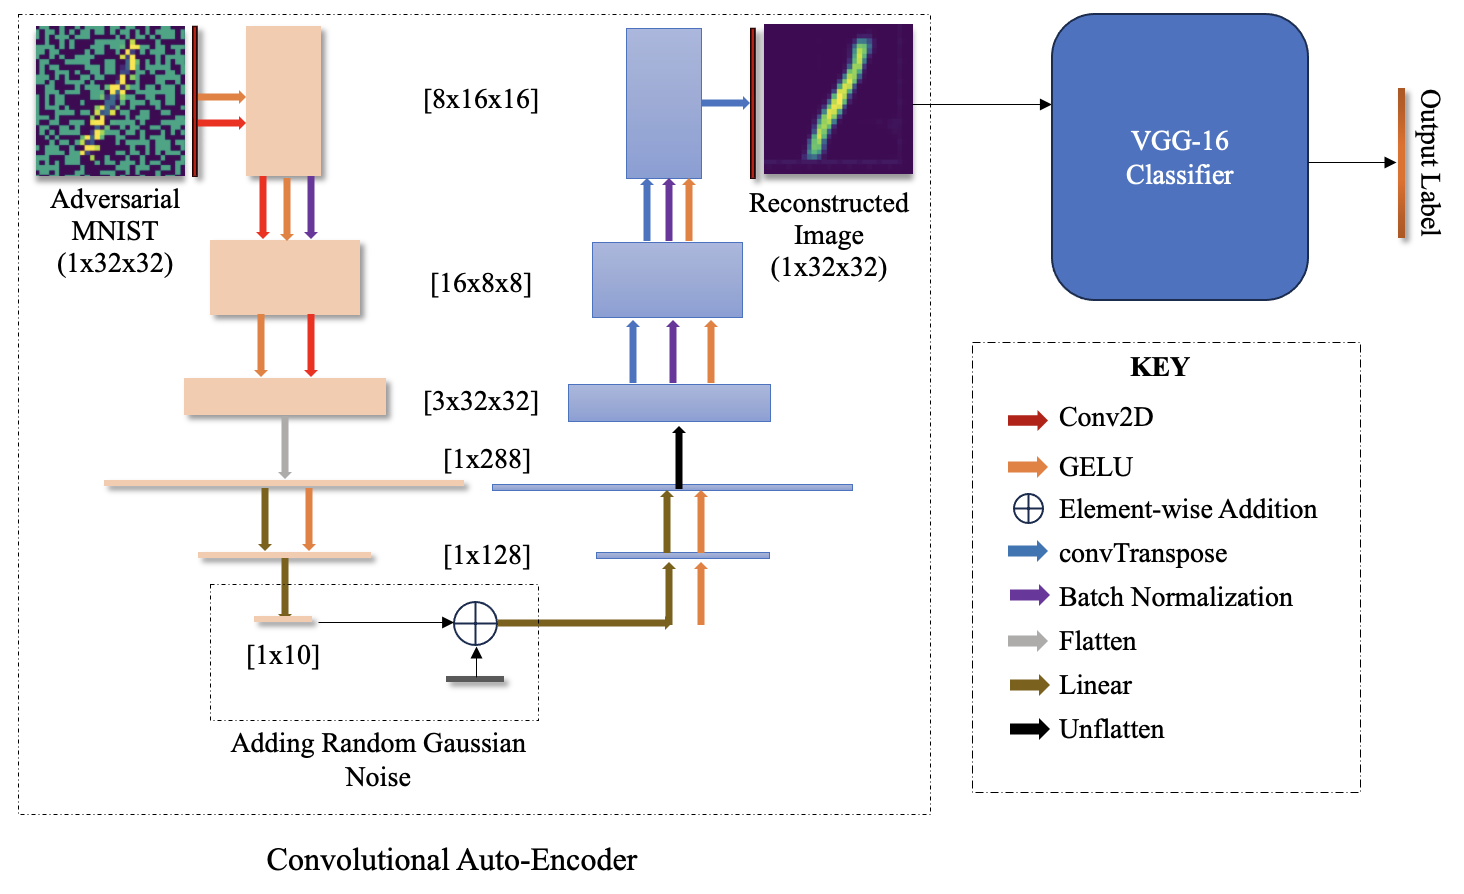

In [14]:
# 卷积自编码器
class ConvAutoencoder_GELU(nn.Module):
    def __init__(self, device, z_dim=10):
        super().__init__()
        self.device = device

        self.encoder_conv2D = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.GELU()
        )

        ## 扁平化层
        self.flatten = nn.Flatten(start_dim=1)
        
        ## 编码器线性部分
        self.encoder_linear = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.GELU(),
            nn.Linear(128, z_dim),
        )

        ## 解码器线性部分
        self.decoder_linear = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.GELU(),
            nn.Linear(128, 3 * 3 * 32),
            nn.GELU(),
        )

        ## 解扁平化层
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        ## 解码器卷积转置层
        self.decoder_convt2d = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.GELU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )


    def forward(self, x):
        x = self.encoder_conv2D(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)

        noise = torch.randn(x.shape).to(self.device)
        x = x + noise

        x = self.decoder_linear(x)
        x = self.unflatten(x)
        x = self.decoder_convt2d(x)
        x = torch.sigmoid(x)
                
        return x

In [15]:
convAE = ConvAutoencoder_GELU(device)
convAE.to(device)

summary(convAE, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]              80
              GELU-2            [-1, 8, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           1,168
       BatchNorm2d-4             [-1, 16, 8, 8]              32
              GELU-5             [-1, 16, 8, 8]               0
            Conv2d-6             [-1, 32, 3, 3]           4,640
              GELU-7             [-1, 32, 3, 3]               0
           Flatten-8                  [-1, 288]               0
            Linear-9                  [-1, 128]          36,992
             GELU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
           Linear-12                  [-1, 128]           1,408
             GELU-13                  [-1, 128]               0
           Linear-14                  [

### 早停策略
防止模型过拟合

In [16]:
class EarlyStopping:
    def __init__(self, tolerance=2, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                
early_stopping = EarlyStopping()

### 训练模型

In [17]:
def load_checkpoint(checkpoint):
    convAE.load_state_dict(checkpoint['convAE_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['train_losses'], checkpoint['val_losses']

def save_checkpoint(checkpoint, model_path):
    torch.save(checkpoint, model_path)

In [18]:
# 训练自编码器
def train(model, num_epochs, attack_type, train_loader, val_loader, load_model=False, file_path='/kaggle/working/ae_mnist_fgsm.pth.tar'):
    train_losses, val_losses = [], []
    if load_model:
        train_losses, val_losses = load_checkpoint(torch.load(file_path))
        print("Loaded pre-trained model ...")
    
    start_epoch = len(train_losses)
    start_time = time.time()
    
    for epoch in range(start_epoch, num_epochs):
        train_loss, val_loss = 0.0, 0.0
        train_count, val_count = 0, 0
        for _, (imgs, labels) in enumerate(train_loader):
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == 'fgsm':
                adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
            else:
                adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)
            
            train_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(imgs, rec_imgs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size

        # 验证过程
        for _, (imgs, labels) in enumerate(val_loader):
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))
            if attack_type == 'fgsm':
                adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
            else:
                adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)
            
            val_count += len(adv_imgs)

            adv_imgs = adv_imgs.to(device)

            optimizer.zero_grad()
            rec_imgs = convAE.forward(adv_imgs)
            loss = criterion(imgs, rec_imgs)
            loss.backward()
            optimizer.step()
            val_loss += loss.item() * batch_size

        train_loss, val_loss = train_loss / train_count, val_loss / val_count

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1} / {num_epochs}, Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, \
              Time_taken: {(time.time()-start_time)/60:.2f} mins')

        checkpoint = {
            'convAE_state_dict': convAE.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses, 'val_losses': val_losses
        }

        save_checkpoint(checkpoint, file_path)
        early_stopping(train_loss, val_loss)
        if early_stopping.early_stop:
            print("Early Stopping critieria satisfied")
            break

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('number of epochs')
    plt.legend()

    plt.show()
    plt.close()

In [19]:
def to_numpy_array(tensor):
    tensor_ = tensor.cpu()
    tensor_ = tensor_.squeeze(0)
    tensor_ = tensor_.detach().numpy()
    return tensor_

def visualise(model, val_loader, attack_type):
    count = 0
    for i, (imgs, labels) in enumerate(val_loader):
        if count > 4:
            break
        if i % 3 == 0:
            count += 1
            batch_size = imgs.shape[0]
            imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

            if attack_type == 'fgsm':
                adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
            else:
                adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)

            adv_imgs = adv_imgs.to(device)

            with torch.no_grad():
                rec_imgs = convAE(adv_imgs)

            imgs, adv_imgs, rec_imgs = to_numpy_array(imgs[0]), to_numpy_array(adv_imgs[0]), to_numpy_array(rec_imgs[0])

            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
            ax1.imshow(adv_imgs)
            ax1.set_title("Adversarial Image")
            ax2.imshow(rec_imgs)
            ax2.set_title("Recreated Image")
            ax3.imshow(imgs)
            ax3.set_title("Original Image")

In [20]:
# 参数
lr = 0.001
batch_size = 64
num_epochs = 15
z_dim = 10

# FGSM 参数
eps_fgsm = 0.6

# PGD 参数
eps_pgd, alpha, num_iter = 0.15, 1e-2, 40

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(convAE.parameters(), lr=lr)

Epoch: 1 / 15, Train_loss: 0.0587, Val_loss: 0.0276,               Time_taken: 0.54 mins
Epoch: 2 / 15, Train_loss: 0.0228, Val_loss: 0.0202,               Time_taken: 1.07 mins
Epoch: 3 / 15, Train_loss: 0.0188, Val_loss: 0.0178,               Time_taken: 1.59 mins
Epoch: 4 / 15, Train_loss: 0.0171, Val_loss: 0.0165,               Time_taken: 2.12 mins
Epoch: 5 / 15, Train_loss: 0.0161, Val_loss: 0.0157,               Time_taken: 2.64 mins
Epoch: 6 / 15, Train_loss: 0.0154, Val_loss: 0.0151,               Time_taken: 3.17 mins
Epoch: 7 / 15, Train_loss: 0.0149, Val_loss: 0.0146,               Time_taken: 3.69 mins
Epoch: 8 / 15, Train_loss: 0.0145, Val_loss: 0.0143,               Time_taken: 4.22 mins
Epoch: 9 / 15, Train_loss: 0.0142, Val_loss: 0.0140,               Time_taken: 4.75 mins
Epoch: 10 / 15, Train_loss: 0.0139, Val_loss: 0.0138,               Time_taken: 5.27 mins
Epoch: 11 / 15, Train_loss: 0.0136, Val_loss: 0.0134,               Time_taken: 5.80 mins
Epoch: 12 / 15, Tra

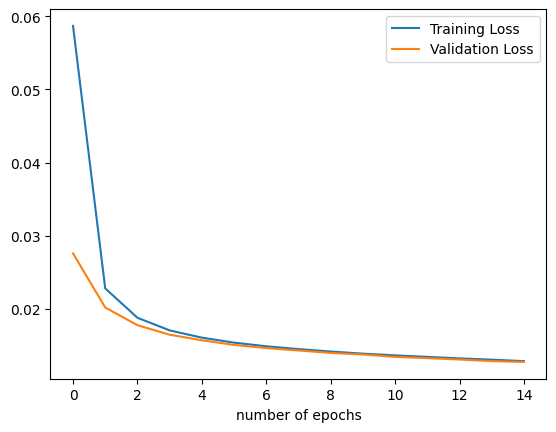

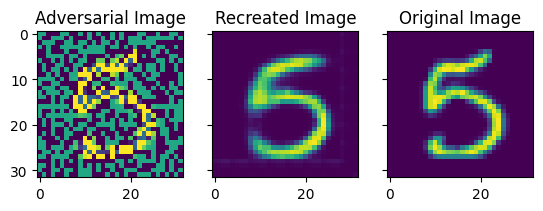

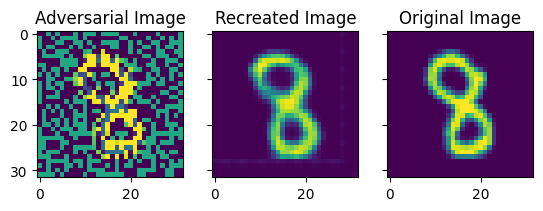

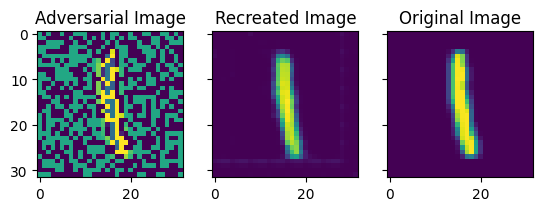

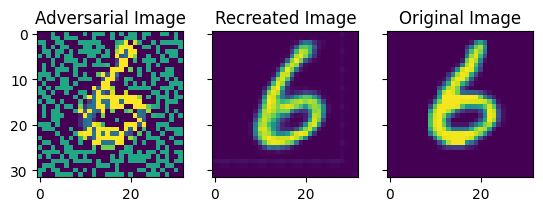

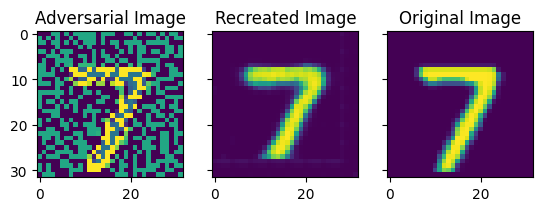

In [22]:
# FGSM 攻击
attack_type = 'fgsm'
file_path = './working/ae_mnist_fgsm.pth.tar'
train(model_mnist, num_epochs, attack_type, train_mnist, val_mnist, load_model=False, file_path=file_path)
visualise(model_mnist, val_mnist, attack_type)

Epoch: 1 / 5, Train_loss: 0.0186, Val_loss: 0.0145,               Time_taken: 12.89 mins
Epoch: 2 / 5, Train_loss: 0.0135, Val_loss: 0.0128,               Time_taken: 25.78 mins
Epoch: 3 / 5, Train_loss: 0.0124, Val_loss: 0.0121,               Time_taken: 38.70 mins
Epoch: 4 / 5, Train_loss: 0.0118, Val_loss: 0.0116,               Time_taken: 51.60 mins
Epoch: 5 / 5, Train_loss: 0.0114, Val_loss: 0.0112,               Time_taken: 64.49 mins


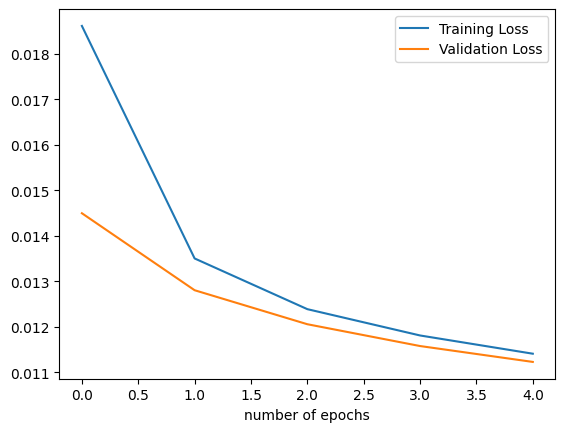

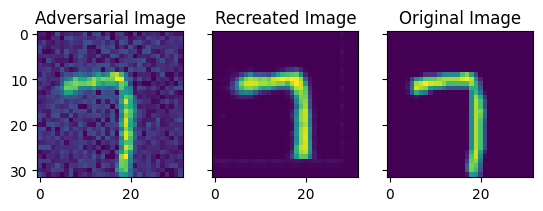

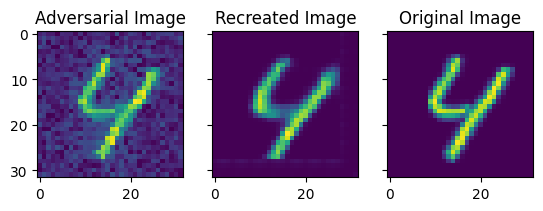

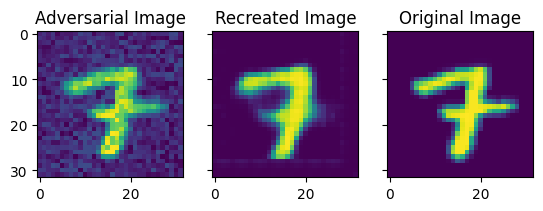

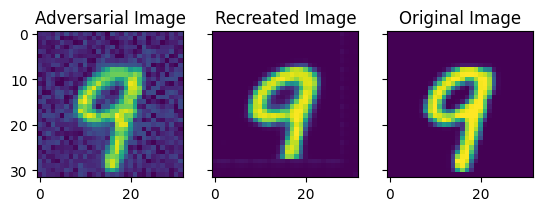

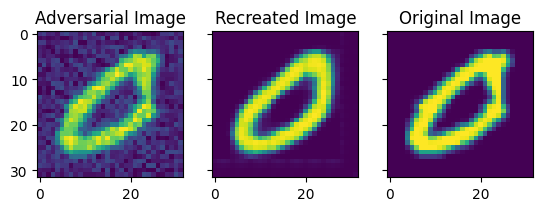

In [24]:
# PGD 攻击
attack_type = 'pgd'
file_path = './working/ae_mnist_pgd.pth.tar'
train(model_mnist, 5, attack_type, train_mnist, val_mnist, load_model=False, file_path=file_path)
visualise(model_mnist, val_mnist, attack_type)

## 卷积自编码器防御架构在对抗样本上的性能测试
评估该架构对抗不同类型的对抗性攻击（如FGSM和PGD）后，恢复图像并进行分类的准确性和效率。

In [26]:
# 性能测试
def test(model, test_loader, attack_type, file_path):
    convAE = ConvAutoencoder_GELU(device)
    convAE.to(device)
    convAE.load_state_dict(torch.load(file_path)['convAE_state_dict'])
    
    correct, total = 0, 0
    
    tot_time = 0

    for _, (imgs, labels) in enumerate(test_loader):
        batch_size = imgs.shape[0]
        imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

        if attack_type == 'fgsm':
            adv_imgs, _ = fgsm_attack(model, imgs, labels, eps_fgsm)
        else:
            adv_imgs, _ = pgd_linf(model, imgs, labels, eps_pgd, alpha, num_iter)

        adv_imgs = adv_imgs.to(device)
        
        time_comp = time.time()

        with torch.no_grad():
            rec_imgs = convAE(adv_imgs)

        y_preds = model(rec_imgs).argmax(dim=1)
        correct += (y_preds == labels).sum().item()
        total += labels.size(0)
        
        tot_time += (time.time() - time_comp)

    print("Test Accuracy: {}".format(correct / total))
    print(f'Time taken for defense against a single instance of attack: {(tot_time)/10000:.4f} sec')
    print(f'Total time taken: {tot_time:.4f} sec')

In [27]:
# FGSM攻击的测试
attack_type = 'fgsm'
file_path = './working/ae_mnist_fgsm.pth.tar'
test(model_mnist, test_mnist, attack_type, file_path)

Test Accuracy: 0.916
Time taken for defense against a single instance of attack: 0.0003 sec
Total time taken: 2.8159 sec


In [29]:
# PGD攻击的测试
attack_type = 'pgd'
file_path = './working/ae_mnist_pgd.pth.tar'
test(model_mnist, test_mnist, attack_type, file_path)

Test Accuracy: 0.9366
Time taken for defense against a single instance of attack: 0.0012 sec
Total time taken: 11.8059 sec
